# Lesson 08 - Redes Convolucionais

## Objetivo
Utilizar uma Rede Neural Convolucional para diferenciar entre estrela do mar e orca.

## 1. Instalação

In [141]:
!pip install -qqq fastai duckduckgo_search torch

In [142]:
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from duckduckgo_search import ddg_images
from time import sleep
from PIL import Image
import numpy as np

## 2. Procurando imagens

In [143]:
def search_images(term, max_images=300):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


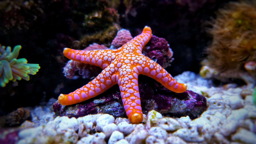

In [144]:
starfish = search_images('starfish', max_images=1)[0]
download_url(starfish, 'starfish.jpg', show_progress=False)

Image.open('shark.jpg').to_thumb(256, 256)

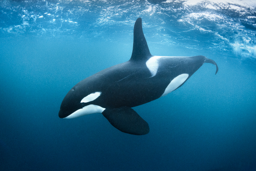

In [145]:
k_whale = search_images('killer whale', max_images=1)[0]
download_url(k_whale, 'k_whale.jpg', show_progress=False)

Image.open('k_whale.jpg').to_thumb(256, 256)

baixando mais exemplos para usar como a nossa base de dados

In [146]:
searchs = 'starfish', 'killer whale'
path = Path('anim')

for anim in searchs:
    dest = (path/anim)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{anim}'))
    sleep(1)
    resize_images(path/anim, max_size=400, dest=path/anim)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Vamos remover imagens cujo download não foi bem sucedido

In [147]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

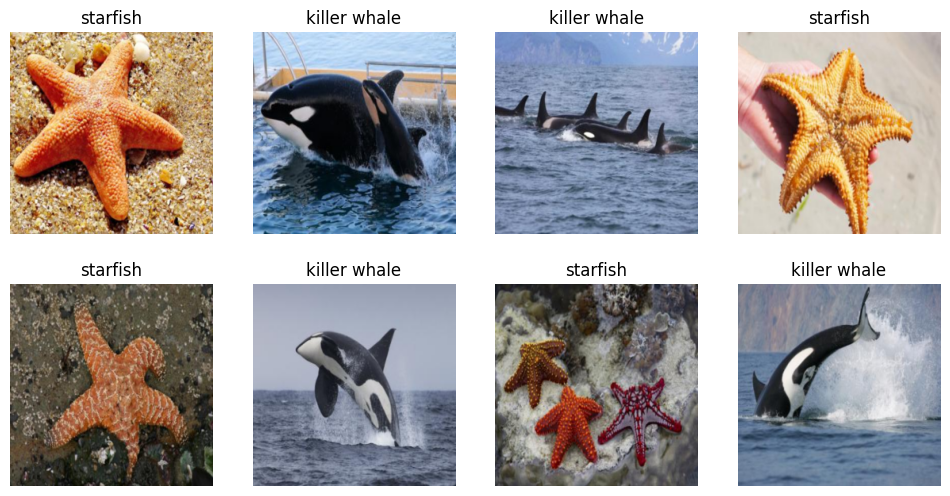

In [148]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

## 3. Rede Neural Convolucional


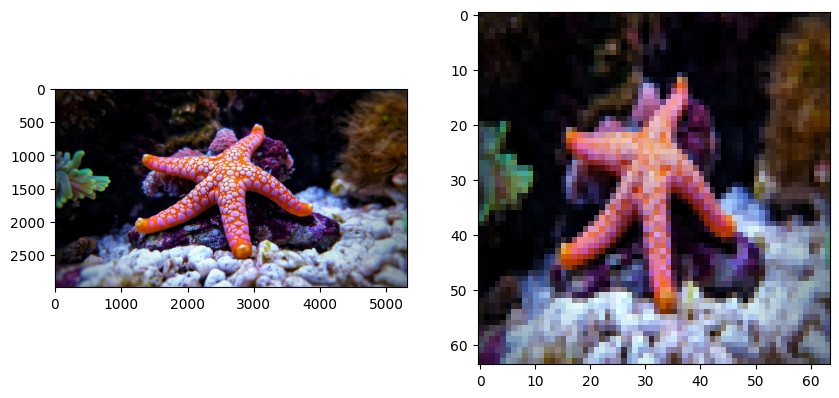

In [149]:
starfish_path = 'starfish.jpg'
starfish = Image.open(starfish_path)

starfish_resized = starfish.resize((64 ,64))

new_starfish = np.asarray(starfish_resized)
initial_starfish = np.asarray(starfish, dtype=np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(initial_starfish)
axs[1].imshow(new_starfish)

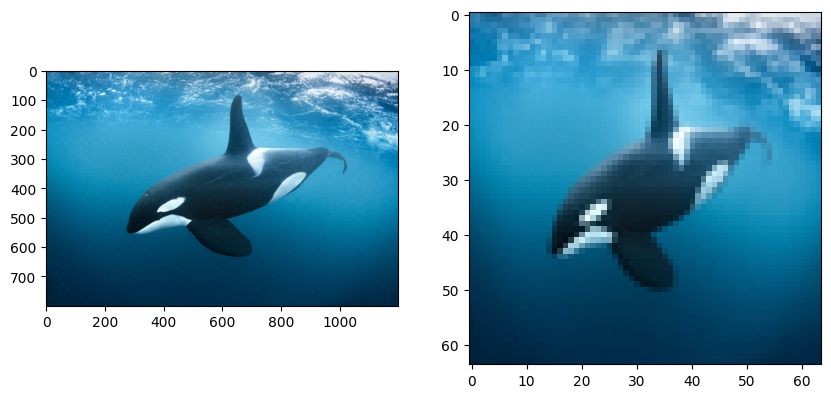

In [150]:
k_whale_path = 'k_whale.jpg'
k_whale = Image.open(k_whale_path)

k_whale_resized = k_whale.resize((64 ,64))

new_k_whale = np.asarray(k_whale_resized)
initial_k_whale = np.asarray(k_whale, dtype=np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(initial_k_whale)
axs[1].imshow(new_k_whale)

Testando filtro de convolução para modificar imagem:

In [151]:
plot = {}
for y in range(3):
    for x in range(3):
        value_x = 23+x
        value_y = 23+y
        plot[f'{value_x}:{value_y}'] = new_starfish[value_x][value_y]

plot

{'23:23': array([241, 166, 146], dtype=uint8),
 '24:23': array([233, 140, 109], dtype=uint8),
 '25:23': array([220, 137, 146], dtype=uint8),
 '23:24': array([242, 186, 161], dtype=uint8),
 '24:24': array([229, 171, 183], dtype=uint8),
 '25:24': array([220, 152, 169], dtype=uint8),
 '23:25': array([239, 181, 169], dtype=uint8),
 '24:25': array([229, 155, 141], dtype=uint8),
 '25:25': array([217, 132, 114], dtype=uint8)}

In [152]:
filter_1 = np.zeros((3,3,3), dtype=float)

filter_1[0][0][0] = 0.8
filter_1[0][0][1] = 0.2
filter_1[0][0][2] = 0.8

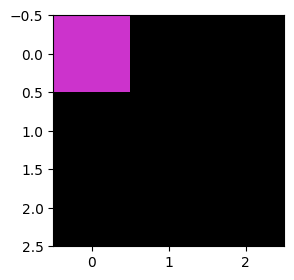

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.imshow(filter_1)

In [154]:
img_2 = np.zeros((64,64,3), dtype=float)

for i in range(50):
    for j in range(50):
        img_2[i][j][0] = new_starfish[:,:,0][i][j] * 0.2
        img_2[i][j][1] = new_starfish[:,:,1][i][j] * 0.8
        img_2[i][j][2] = new_starfish[:,:,2][i][j] * 0.5

img_2 = np.asarray(img_2, dtype=np.uint8)
np.shape(img_2)

(64, 64, 3)

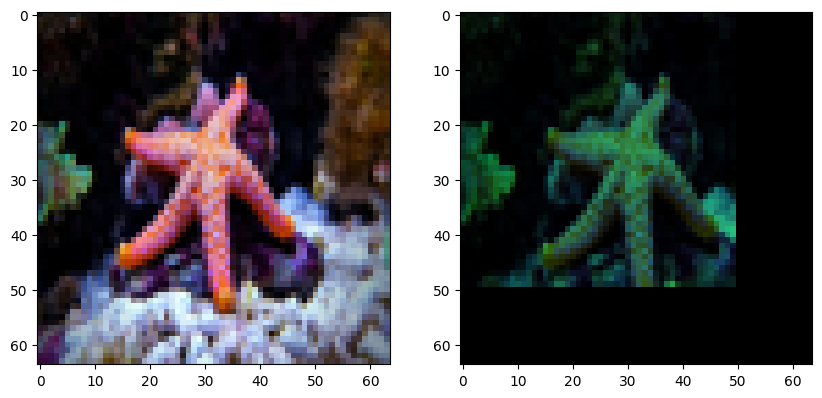

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(new_starfish)
axs[1].imshow(img_2)

Testando modificar nitidez da imagem:

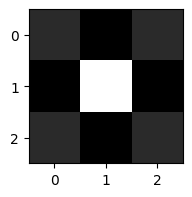

In [156]:
sharpness = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.imshow(sharpness, cmap='gray')
plt.show()

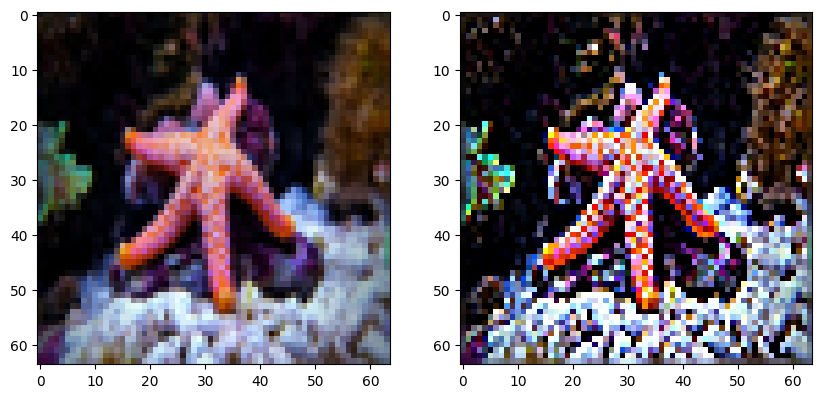

In [157]:
starfish_copy = new_starfish.copy()
height, width, _ = starfish_copy.shape

for color in range(3):
    for i in range(1, height-1):
        for j in range(1, width-1):
            sum = 0
            for ki in range(-1, 2):
                for kj in range(-1, 2):
                    sum += new_starfish[i+ki, j+kj, color] * sharpness[ki+1][kj+1]
            starfish_copy[i, j, color] = min(max(int(sum), 0), 255)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(new_starfish)
axs[1].imshow(starfish_copy)

## 5. Modelo usando resnet

In [158]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.702617,0.009470,0.000000,1.000000,00:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.006959,0.000295,0.000000,1.000000,00:02
1,0.005314,0.000047,0.000000,1.000000,00:02
2,0.003298,0.000139,0.000000,1.000000,00:02


## 6. Testando nos exemplos

In [163]:
is_starfish, _, probs = learn.predict(PILImage.create('starfish.jpg'))
print(f"{is_starfish}.")
print(f"Probabilidade: {probs[1]:.4f}")

starfish.
Probabilidade: 1.0000


In [164]:
is_killer_whale, _, probs = learn.predict(PILImage.create('k_whale.jpg'))
print(f"{is_killer_whale}.")
print(f"Probabilidade: {1 - probs[1]:.4f}")

killer whale.
Probabilidade: 0.9999


## 6. Hugging Face

Link: [https://huggingface.co/spaces/fastaioncampus/starfish_or_killer_whale](https://huggingface.co/spaces/fastaioncampus/starfish_or_killer_whale)

In [165]:
learn.export('model.pkl')